<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter07/ch7_nb7_generate_images_with_vae_models.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 7: Training on Complex and Scarce Datasets</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 7:</small><br/>Generating Images with VAEs</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    Besides classic computer graphics tools, computer vision  models can also be built to edit images or generate new ones.<br/><br/>
    In this notebook, we will implement a simple <strong>Variational Auto-Encoder (<em>VAE</em>)</strong> (refer to Chapter 7 for the theoretical explanations), and we will train it to generate digit images.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Preparing the Dataset

As readers may have guessed, we will use once again the [MNIST](http://yann.lecun.com/exdb/mnist) dataset[$^1$](#ref) to teach a neural network how to generate new digit images.

Therefore, similar to what we did for Notebook [6-1](../Chapter06/ch6_nb1_discover_autoencoders.ipynb), we build data pipelines simply pre-processing and feeding the dataset images (no labels):

In [2]:
# num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)
batch_size = 100
num_epochs = 91

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.apply(
    tf.data.experimental.shuffle_and_repeat(len(x_train), num_epochs, random_seed))
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test)
val_dataset = val_dataset.batch(batch_size)


train_steps_per_epoch = math.ceil(x_train.shape[0] / batch_size)
val_steps_per_epoch   = math.ceil(x_test.shape[0] / batch_size)

In [5]:
from plot_utils import plot_image_grid

num_show = 9
val_dataset_samples = val_dataset.take(1)
val_samples = next(val_dataset_samples.__iter__())[:num_show]

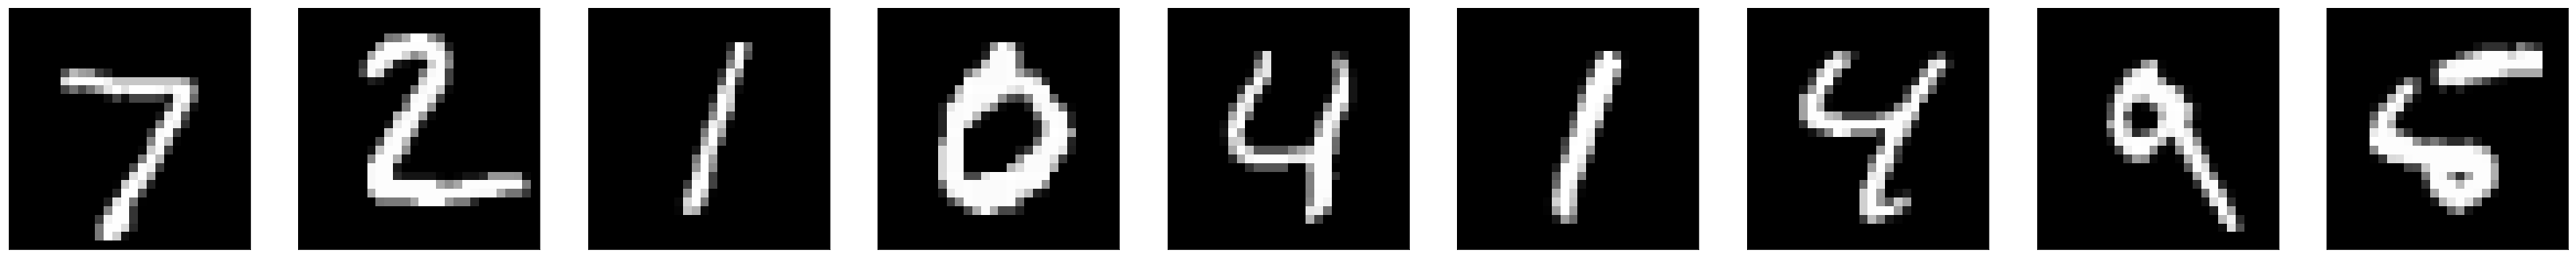

In [19]:
figure = plot_image_grid([val_samples.numpy()[..., 0]], grayscale=True, transpose=True)
figure.show()

## Creating a Variational Auto-Encoder

In this section, we will demonstrate how to build a VAE[$^2$](#ref).

### DAE Sub-Networks

Like (deep) auto-encoders, VAEs are composed of an encoder sub-network and a decoder one. Only the latent space connecting the two is defined differently (c.f. Chapter 7).

Therefore, we start by defining the simple convolutional encoder and decoder we will use for our experiment (inspired from Notebook [6-3](../Chapter06/ch6_nb3_improve_image_quality_with_dae.ipynb)):

In [7]:
# Network hyper-parameters:
kernel_size  = 3
filters_orig = 32
layer_depth  = 2
latent_dim   = 2

In [8]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (Input, InputLayer, Lambda, Conv2D, 
                                     Flatten, Dense, Reshape, Conv2DTranspose)

# c.f. DAE architecture in Chapter 6, Notebook 3
def simple_encoder(input_shape, latent_dim=32, 
                   kernel_size=4, filters_orig=32, layer_depth=4,
                   final_activation=None, name='encoder'):
    """
    Build a simple encoder network.
    :param input_shape:      Shape of the input image (H x W x C)
    :param latent_dim:       Size of the latent space
    :param kernel_size:      Kernel size for the convolutions
    :param filters_orig:     Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:      Number of layers composing the encoder/decoder
    :param final_activation: Activation function for the last layer
    :param name:             Model name
    :return:                 Encoder model
    """
    
    return Sequential([
        # Taking images as inputs:
        InputLayer(input_shape=input_shape),
        # Adding conv layers to extract features:
        *[Conv2D(filters=min(filters_orig * (2 ** i), 512), 
                 kernel_size=kernel_size, activation='relu', strides=2, 
                 padding='same')
          for i in range(layer_depth)],
        # Flattening feature vectors
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(latent_dim, activation=final_activation)
    ], name=name)
    
def simple_decoder(output_shape, latent_dim=32, 
                   kernel_size=4, filters_orig=32, layer_depth=4,
                   final_activation=None, name='decoder'):
    """
    Build a simple decoder network.
    :param output_shape:     Shape of the output image (H x W x C)
    :param latent_dim:       Size of the latent space
    :param kernel_size:      Kernel size for the convolutions
    :param filters_orig:     Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:      Number of layers composing the encoder/decoder
    :param final_activation: Activation function for the last layer
    :param name:             Model name
    :return:                 Decoder model
    """
    
    # c.f. Chapter 6, Notebook 3
    ResizeToOutputShapeLayer = lambda name: Lambda(
            lambda images: tf.image.resize(images, output_shape[:2]), name=name)
    
    divided_size = np.ceil(np.asarray(output_shape[:2]) / (2 ** layer_depth)).astype(np.int32)
    
    return Sequential([
        # Taking codes from the latent space as inputs:
        InputLayer(input_shape=(latent_dim,)),
        # Extending and reshaping into a 2D feature map:
        Dense(units=divided_size[0] * divided_size[1] * latent_dim, activation=tf.nn.relu),
        Reshape(target_shape=(*divided_size, latent_dim)),
        # Upsampling/convolving to decode into an image:
        *[Conv2DTranspose(filters=min(filters_orig * (2 ** (layer_depth - i - 1)), 512), 
                          kernel_size=kernel_size, activation='relu', strides=2, 
                          padding='same')
          for i in range(layer_depth)],
        # Making sure to get back the original dimensions:
        ResizeToOutputShapeLayer('resize_to_orig'),
        # Decoding and outputting the image:
        Conv2DTranspose(filters=input_shape[-1], kernel_size=3, 
                        activation=final_activation,
                        strides=1, padding='same')
    ], name=name)

We now instantiate the two sub-networks which will form our VAE. We create the encoder so that it output vectors twice the size of the latent space (as we will then split these vectors in two, as the means and standard deviations used to sample the actual codes):

In [9]:
# We build the encoder to output 2 vectors of `latent_dim`, 
# for the mean and std-dev:
vae_encoder = simple_encoder(input_shape, latent_dim * 2, kernel_size, 
                             filters_orig, layer_depth, None)
vae_encoder.summary() 

vae_decoder = simple_decoder(input_shape, latent_dim, kernel_size, 
                             filters_orig, layer_depth, 'sigmoid')

vae_decoder.summary() 

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 12548     
Total params: 31,364
Trainable params: 31,364
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 98)                294       
______________________________________

### Reparameterization Trick and Complete VAE

The mean and standard-deviation vectors provided by the encoder are used to randomly sample the actual code representing the input image. As explained in Chapter 7, this procedure is done by applying the *reparameterization trick* so that the auto-encoder loss can still flow through the complete network despite thefact that random sampling operations are not derivable.

To that purpose, we create two custom Keras layers: one to slice the encoder's output vectors in two, and one to perform the sampling:

In [10]:
def reparameterize_and_sample(z_mean, z_log_var):
    """
    Sample a vector from the random normal distribution, using the
    reparameterization trick.
    Note: `log(var)` (with `var` the distribution variance) is asked as
          parameter rather than `var` or `sqrt(var)` (standard deviation)
          to simplify the network's task. Indeed, if we do not constrain the
          encoder, it can by default output negative or positive values; but
          the variance should be strictly positive. Therefore, we simply consider
          the encoder's output as being the variance on a log scale, c.f.
          var = exp(log(var)) always > 0.
    :param z_mean: 
    :param z_log_var: 
    :return: 
    """
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0, stddev=1)
    z = z_mean + epsilon * tf.math.exp(z_log_var)
    return z

MeanAndLogvarSliceLayer = Lambda(
    lambda args: [tf.reshape(args[..., :latent_dim], (-1, latent_dim)),
                   tf.reshape(args[..., latent_dim:], (-1, latent_dim))],
    name='z_mean-z_logvar_slicer')
ReparameterizationLayer = Lambda(
    lambda args: reparameterize_and_sample(args[0], 
                                           args[1]),
    name='z_sampler')

Having all the components in place, we can now put everything together to obtain our simple convolutional VAE:

In [11]:
# Building the VAE with Keras Functional API:
inputs = Input(shape=input_shape, name='input_imgs')
encoder_outputs = vae_encoder(inputs)
z_mean, z_log_sigma = MeanAndLogvarSliceLayer(encoder_outputs)
z = ReparameterizationLayer([z_mean, z_log_sigma])
output = vae_decoder(z)

# To train the model, two losses are applied:
# - a MSE loss on the decoder output to compare it with the original image
# - a KL-based loss to ensure the mean and standard deviation outputted by the
#   encoder represent a standard normal distribution
# Therefore, we collect both the decoder and encoder's outputs to compute these
# losses:
vae_model = Model(inputs, [output, encoder_outputs])
vae_model.summary(positions=[.35, .65, .75, 1.]) # `positions` adapts the printed cols' width.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                 Param #   Connected to             
input_imgs (InputLayer)           [(None, 28, 28, 1)]          0                                  
__________________________________________________________________________________________________
encoder (Sequential)              (None, 4)                    31364     input_imgs[0][0]         
__________________________________________________________________________________________________
z_mean-z_logvar_slicer (Lambda)   [(None, 2), (None, 2)]       0         encoder[1][0]            
__________________________________________________________________________________________________
z_sampler (Lambda)                (None, 2)                    0         z_mean-z_logvar_slicer[0]
                                                                         z_mean-z_logvar_slice


## Training and Testing a VAE

Like normal AEs, VAEs are trained by comparing the generated images with the original ones, for instance by computing the _MSE_ loss over the data pairs (c.f. Chapter 6). However, VAEs require a second loss, to ensure that the data distributions inferred by the encoder have a proper form. For that, the _KL loss_[$^3$](#ref) is computed over the encoder's output (c.f. Chapter 7).

This is why, to simplify the training loop, we defined our VAE model so that it outputs not only the generated images, but also the encoder output, so that we have the data to compute both losses.

In [12]:
import tensorflow.keras.backend as K

def KL_loss(y_true, y_pred):
    z_mean, z_log_sigma = MeanAndLogvarSliceLayer(y_pred)
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return kl_loss


def mse_loss(y_true, y_pred):
    mse = tf.losses.mse(y_true, y_pred)
    mse = K.sum(mse, axis=[i for i in range(1, len(mse.shape))])
    return mse

In [13]:
vae_model.compile(optimizer='adam', loss=[mse_loss, KL_loss])

We adapt our input pipelines so that the ground-truths for the losses are provided. For the MSE loss, the original image is copied as target. For the KL loss, no ground-truths are actually needed to compute this loss (as it only evaluates the correctness of the means and standard deviations generated by the encoder).
However, Keras requires that a ground-truth object is provided for each loss. Therefore, to circumvent this limitation, we simply pass a dummy tensor to Keras as ground-truth for the second loss.

In [14]:
none_tensor = tf.constant(0)
train_dataset_with_gt = train_dataset.map(lambda x: (x, (x, none_tensor)))
val_dataset_with_gt = val_dataset.map(lambda x: (x, (x, none_tensor)))

Finally, we set up the usual metrics and callbacks, before starting the training:

In [15]:
import collections
from keras_custom_callbacks import SimpleLogCallback, TensorBoardImageGridCallback

model_name = 'mnist_vae'
model_dir = os.path.join('models', model_name)

def process_images_before_plot(input_imgs, pred_data, target_imgs=None):
    pred_imgs = pred_data[0]
    # print(np.sum((pred_imgs != 0.))
    return input_imgs[..., 0], pred_imgs[..., 0], target_imgs

# Callback to postprocess some validation results and display them in Tensorboard:
callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, preprocess_fn=process_images_before_plot,
    input_images=val_samples, target_images=None, 
    grayscale=True, transpose=True,
    tag=model_name + '_results', figsize=(10, 10))

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("loss", "loss"), ("val-loss", "val_loss"),
                                            ("KL", "encoder_loss"), ("val-KL", "val_encoder_loss"),
                                            ("MSE", "decoder_loss"), ("val-MSE", "val_decoder_loss")])
callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=2)


<Figure size 3000x3000 with 0 Axes>

In [16]:
callbacks = [
    # Callback to interrupt the training if the loss stops decreasing:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', mode='min',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callbacks to log some results as image grids into TensorBoard:
    callback_tb_grid
]


history = vae_model.fit(
    train_dataset_with_gt, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset_with_gt, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  1/91: loss = 45.994; val-loss = 45.598; KL = 1.740; val-KL = 1.843; MSE = 44.253; val-MSE = 43.755
Epoch  3/91: loss = 43.050; val-loss = 42.504; KL = 1.912; val-KL = 2.010; MSE = 41.137; val-MSE = 40.493
Epoch  5/91: loss = 41.467; val-loss = 41.234; KL = 2.041; val-KL = 2.115; MSE = 39.426; val-MSE = 39.118
Epoch  7/91: loss = 40.233; val-loss = 40.018; KL = 2.159; val-KL = 2.201; MSE = 38.074; val-MSE = 37.816
Epoch  9/91: loss = 39.337; val-loss = 39.223; KL = 2.253; val-KL = 2.296; MSE = 37.084; val-MSE = 36.926
Epoch 11/91: loss = 38.803; val-loss = 38.772; KL = 2.327; val-KL = 2.265; MSE = 36.476; val-MSE = 36.507
Epoch 13/91: loss = 38.401; val-loss = 38.528; KL = 2.354; val-KL = 2.318; MSE = 36.046; val-MSE = 36.210
Epoch 15/91: loss = 38.120; val-loss = 38.256; KL = 2.395; val-KL = 2.348; MSE = 35.726; val-MSE = 35.908
Epoch 17/91: loss = 37.832; val-loss = 37.861; KL = 2.409; val-KL = 2.382; MSE = 35.424; val-MSE = 35.479
Epoch 19/91: loss = 37.638; v

Once the VAE trained, its decoder can be used to generate novel images, simply by passing it a random or chosen code. The key property of VAE is indeed that, because of their specific sampling and training, their latent space is continuous. This means that if the model is properly trained, any code vector in their latent space should correspond to a valid image.

As an example, we pick some random code vectors and pass them to the decoder:

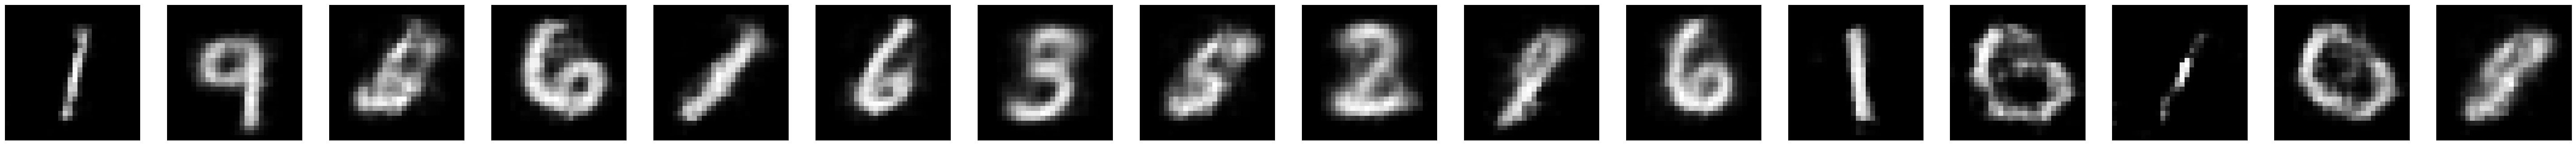

In [17]:
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
images = vae_decoder(random_vector_for_generation)
images = np.reshape(images, (num_examples_to_generate, img_rows, img_cols))

figure = plot_image_grid([images], grayscale=True, transpose=True)
figure.show()

***Note:*** We used a really simple model, hence the noisy results. State-of-the-art VAEs are commonly used to obtain highly realistic images.

These input vectors can also be purposedly chosen. For example: we built here a VAE with a two-dimensional latent space. If we divide this 2D latent space with a fixed grid and if we pick a code vector corresponding to each grid intersection, we can, therefore, explore the latent space homogeneously to observe the resulting images:

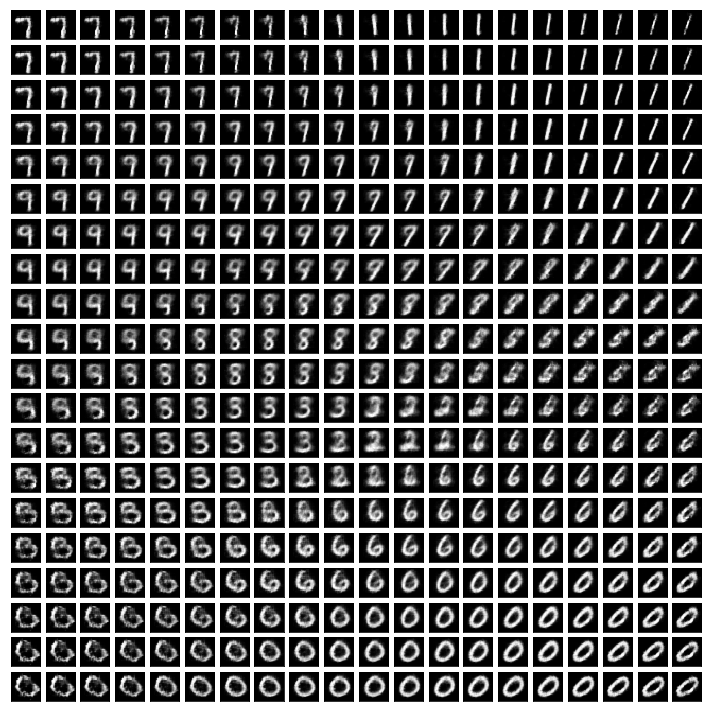

In [18]:
# We built a 2D latent space, so let us explore it.

dim1_num, dim2_num = 20, 20
dim1_grid = np.linspace(-1.5, 1.5, dim1_num)
dim2_grid = np.linspace(-1.5, 1.5, dim2_num)

z_samples = []
for dim1_val in dim1_grid:
    for dim2_val in dim2_grid:
        z_sample = np.array([dim1_val, dim2_val])
        z_samples.append(z_sample)

z_samples = np.stack(z_samples, axis=0)
images = vae_decoder.predict(z_samples) 
images = np.reshape(images, (dim1_num, dim2_num, img_rows, img_cols))
   
figure = plot_image_grid(images, 
                         figure=plt.figure(figsize=(10, 10)),
                         grayscale=True)
figure.show()

Displaying the generated images to map the grid layout, we can definitely notice the continuous nature of the VAE latent space. The shape and value of the digits smoothly evolve from one code vector to another.

## Conclusion

In this notebook, we trained our first ***generative*** model: a simple ***VAE*** to generate digit images. In the next experiment, we will tackle the same task but with a different type of generative models: the ***GANs***.

<a id="ref"></a>
#### References

1. 1. LeCun, Y., Cortes, C., Burges, C., 2010. MNIST handwritten digit database. AT&T Labs [Online]. Available: http://yann.lecun.com/exdb/mnist 2, 18.
2. Kingma, D.P. and Welling, M., 2013. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.
3. Kullback, S. and Leibler, R.A., 1951. On information and sufficiency. The annals of mathematical statistics, 22(1), pp.79-86.